# Checkpoint 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
# import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


# /content/drive/MyDrive/checkpoints/checkpoint2.pkl
with open('/content/drive/MyDrive/checkpoint2.pkl', 'rb') as f:
    checkpoint2 = pkl.load(f)

# Accessing variables
X_train = checkpoint2['X_train']
y_train = checkpoint2['y_train']
X_val = checkpoint2['X_val']
X_test = checkpoint2['X_test']
y_val = checkpoint2['y_val']
y_test = checkpoint2['y_test']
data_cleaned = checkpoint2['data_cleaned']

print("Checkpoint loaded successfully")


total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
# Verify the splits
print(f"Training percentage: {(X_train.shape[0])/total*100}")
print(f"Validation percentage: {(X_val.shape[0])/total*100}")
print(f"Test percentage: {(X_test.shape[0])/total*100}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Checkpoint loaded successfully
Training percentage: 69.99827794041674
Validation percentage: 14.99913897020837
Test percentage: 15.002583089374893


In [3]:
!pip install iterative-stratification torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


In [7]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score, precision_recall_curve
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaled_tfidf = tfidf_features.toarray()
    # scaler = StandardScaler(with_mean=False)
    # scaler.fit(tfidf_features[train_idx])
    # scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # TODO: Check this!
    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb, tfidf_vectorizer, train_idx, val_idx, test_idx

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function (Not used, can be removed or updated)
# ========================================
def evaluate(model, data, mlb):
    pass  # This function is not updated since we are using evaluate_final_model

# ========================================
# Objective Function for Hyperparameter Optimization
# ========================================
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=hidden_dim,
        output_dim=data.num_classes,
        dropout_rate=dropout_rate
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# ========================================
# Prepare Data and Run Hyperparameter Optimization
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace the following line with your actual data loading code
# data_cleaned = pd.read_csv('your_data.csv')  # Uncomment and modify accordingly
# ========================================
# Prepare Data
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb, tfidf_vectorizer, train_idx, val_idx, test_idx = preprocess_data(data_cleaned)

# Retrieve actual feature names from TF-IDF Vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names = tfidf_feature_names.tolist()

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model


'''
Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05
'''
# Best Hyperparameters:
best_params = {
    'lr': 0.0019890464522561964,
    'hidden_dim': 192,
    'dropout_rate': 0.30000000000000004,
    'weight_decay': 2.2578844005086472e-05
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# # Retrieve the best hyperparameters
# best_params = study.best_trial.params
# print("\nBest Hyperparameters:")
# for key, value in best_params.items():
#     print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Functions to Compute Optimal Thresholds and Apply Them
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue

        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds[None, :]).astype(int)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_scores = y_pred[data.val_mask]
        val_true = data.y[data.val_mask].cpu().numpy()

        # Compute optimal thresholds on validation set
        optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

        # Apply thresholds to validation predictions
        val_pred = apply_thresholds(val_scores, optimal_thresholds)

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average
        num_labels = val_true.shape[1]
        kappa_scores = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
            kappa_scores.append(kappa)

        # Calculate average kappa
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")


        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, val_scores, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_scores = y_pred[data.test_mask]
        test_true = data.y[data.test_mask].cpu().numpy()

        # Apply optimal thresholds to test predictions
        test_pred = apply_thresholds(test_scores, optimal_thresholds)

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average for Test Set
        kappa_scores_test = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
            kappa_scores_test.append(kappa)

        # Calculate average kappa for Test Set
        average_kappa_test = np.mean(kappa_scores_test)
        print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, test_scores, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 500)
Scaled TF-IDF Feature Shape: (29035, 500)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 500)
Combined Features Shape: (29065, 500)


[I 2024-11-30 22:34:23,322] A new study created in memory with name: no-name-c251a477-f52b-4e0e-8629-437bcb1da1ba



Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29065, 500], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=500)


<ipython-input-7-d9233f79803c>:253: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-7-d9233f79803c>:256: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-11-30 22:34:49,880] Trial 0 finished with value: 0.6283305883407593 and parameters: {'lr': 0.0019714917708388317, 'hidden_dim': 128, 'dropout_rate': 0.3, 'weight_decay': 0.0004123226659984934}. Best is trial 0 with value: 0.6283305883407593.
[I 2024-11-30 22:35:14,281] Trial 1 finished with value: 0.5891242623329163 and parameters: {'lr': 0.002382533667682445, 'hidden_dim': 128, 'dropout


Best Hyperparameters:
lr: 0.0019890464522561964
hidden_dim: 192
dropout_rate: 0.30000000000000004
weight_decay: 2.2578844005086472e-05

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 1813. 9008. 3581. 3956.]
Negative Counts per Class: [15410. 15003. 15438. 14713. 14659. 15687. 15576.  8381. 13808. 13433.]
Pos Weight per Class: tensor([7.7868, 6.2879, 7.9129, 5.4981, 5.3696, 9.2168, 8.5913, 0.9304, 3.8559,
        3.3956])
Epoch: 001, Loss: 1.1312, Val Loss: 1.1209, Train Accuracy: 0.6574
Epoch: 020, Loss: 0.7579, Val Loss: 0.8218, Train Accuracy: 0.7498
Epoch: 040, Loss: 0.5496, Val Loss: 0.6074, Train Accuracy: 0.8646
Epoch: 060, Loss: 0.4676, Val Loss: 0.5149, Train Accuracy: 0.9126
Epoch: 080, Loss: 0.4264, Val Loss: 0.4668, Train Accuracy: 0.9257
Epoch: 100, Loss: 0.4011, Val Loss: 0.4360, Train Accuracy: 0.9285
Epoch: 120, Loss: 0.3806, Val Loss: 0.4150, Train Accuracy: 0.9301
Epoch: 140, Loss: 0.3618, Val Loss: 0.3989, Train Accuracy: 0.9313
Epoch: 160, Loss: 0.

<ipython-input-7-d9233f79803c>:405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))


Epoch: 001, Loss: 1.1332, Val Loss: 1.1237, Train Accuracy: 0.7077
Epoch: 020, Loss: 0.7576, Val Loss: 0.8304, Train Accuracy: 0.7621
Epoch: 040, Loss: 0.5438, Val Loss: 0.6029, Train Accuracy: 0.8766
Epoch: 060, Loss: 0.4664, Val Loss: 0.5115, Train Accuracy: 0.9149
Epoch: 080, Loss: 0.4268, Val Loss: 0.4651, Train Accuracy: 0.9257
Epoch: 100, Loss: 0.3993, Val Loss: 0.4359, Train Accuracy: 0.9278
Epoch: 120, Loss: 0.3811, Val Loss: 0.4151, Train Accuracy: 0.9297
Epoch: 140, Loss: 0.3638, Val Loss: 0.3995, Train Accuracy: 0.9312
Epoch: 160, Loss: 0.3506, Val Loss: 0.3861, Train Accuracy: 0.9328
Epoch: 180, Loss: 0.3383, Val Loss: 0.3757, Train Accuracy: 0.9334
Epoch: 200, Loss: 0.3260, Val Loss: 0.3668, Train Accuracy: 0.9342

Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.96      0.97       660
   Front_End_Developer       0.98      0.90      0.94       796
        Java_Developer       0.97  

# Model

In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [5]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score, precision_recall_curve
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # TODO: Check this!
    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb, tfidf_vectorizer, scaler, train_idx, val_idx, test_idx

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function (Not used, can be removed or updated)
# ========================================
def evaluate(model, data, mlb):
    pass  # This function is not updated since we are using evaluate_final_model

# ========================================
# Objective Function for Hyperparameter Optimization
# ========================================
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=hidden_dim,
        output_dim=data.num_classes,
        dropout_rate=dropout_rate
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# ========================================
# Prepare Data and Run Hyperparameter Optimization
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace the following line with your actual data loading code
# data_cleaned = pd.read_csv('your_data.csv')  # Uncomment and modify accordingly
# ========================================
# Prepare Data
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb, tfidf_vectorizer, scaler, train_idx, val_idx, test_idx = preprocess_data(data_cleaned)

# Retrieve actual feature names from TF-IDF Vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names = tfidf_feature_names.tolist()

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model


'''
Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05
'''
# Best Hyperparameters:
best_params = {
    'lr': 0.0019890464522561964,
    'hidden_dim': 192,
    'dropout_rate': 0.30000000000000004,
    'weight_decay': 2.2578844005086472e-05
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# # Retrieve the best hyperparameters
# best_params = study.best_trial.params
# print("\nBest Hyperparameters:")
# for key, value in best_params.items():
#     print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Functions to Compute Optimal Thresholds and Apply Them
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue

        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds[None, :]).astype(int)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_scores = y_pred[data.val_mask]
        val_true = data.y[data.val_mask].cpu().numpy()

        # Compute optimal thresholds on validation set
        optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

        # Apply thresholds to validation predictions
        val_pred = apply_thresholds(val_scores, optimal_thresholds)

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average
        num_labels = val_true.shape[1]
        kappa_scores = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
            kappa_scores.append(kappa)

        # Calculate average kappa
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")


        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, val_scores, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_scores = y_pred[data.test_mask]
        test_true = data.y[data.test_mask].cpu().numpy()

        # Apply optimal thresholds to test predictions
        test_pred = apply_thresholds(test_scores, optimal_thresholds)

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average for Test Set
        kappa_scores_test = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
            kappa_scores_test.append(kappa)

        # Calculate average kappa for Test Set
        average_kappa_test = np.mean(kappa_scores_test)
        print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, test_scores, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 500)
Scaled TF-IDF Feature Shape: (29035, 500)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 500)
Combined Features Shape: (29065, 500)


[I 2024-11-27 18:52:00,828] A new study created in memory with name: no-name-4bcaaac5-8248-43f0-87d0-f1de9ea14802



Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29065, 500], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=500)


<ipython-input-5-1526465c5917>:252: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-5-1526465c5917>:255: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-11-27 18:52:12,148] Trial 0 finished with value: 1.0019639730453491 and parameters: {'lr': 0.00011534354701695468, 'hidden_dim': 48, 'dropout_rate': 0.6000000000000001, 'weight_decay': 0.00023895189168337533}. Best is trial 0 with value: 1.0019639730453491.
[I 2024-11-27 18:52:24,530] Trial 1 finished with value: 0.4614432752132416 and parameters: {'lr': 0.0013896653345911922, 'hidden_di


Best Hyperparameters:
lr: 0.0019890464522561964
hidden_dim: 192
dropout_rate: 0.30000000000000004
weight_decay: 2.2578844005086472e-05

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 1813. 9008. 3581. 3956.]
Negative Counts per Class: [15410. 15003. 15438. 14713. 14659. 15687. 15576.  8381. 13808. 13433.]
Pos Weight per Class: tensor([7.7868, 6.2879, 7.9129, 5.4981, 5.3696, 9.2168, 8.5913, 0.9304, 3.8559,
        3.3956])
Epoch: 001, Loss: 1.5939, Val Loss: 1.0218, Train Accuracy: 0.5680
Epoch: 020, Loss: 0.5105, Val Loss: 0.4631, Train Accuracy: 0.9091
Epoch: 040, Loss: 0.4128, Val Loss: 0.4232, Train Accuracy: 0.9214
Epoch: 060, Loss: 0.3533, Val Loss: 0.3986, Train Accuracy: 0.9280
Epoch: 080, Loss: 0.3098, Val Loss: 0.3802, Train Accuracy: 0.9326
Epoch: 100, Loss: 0.2783, Val Loss: 0.3666, Train Accuracy: 0.9376
Epoch: 120, Loss: 0.2518, Val Loss: 0.3546, Train Accuracy: 0.9389
Epoch: 140, Loss: 0.2292, Val Loss: 0.3467, Train Accuracy: 0.9413
Epoch: 160, Loss: 0.

<ipython-input-5-1526465c5917>:404: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))


Epoch: 001, Loss: 1.5653, Val Loss: 1.0185, Train Accuracy: 0.6660
Epoch: 020, Loss: 0.4995, Val Loss: 0.4607, Train Accuracy: 0.9182
Epoch: 040, Loss: 0.4071, Val Loss: 0.4183, Train Accuracy: 0.9274
Epoch: 060, Loss: 0.3508, Val Loss: 0.4018, Train Accuracy: 0.9310
Epoch: 080, Loss: 0.3114, Val Loss: 0.3840, Train Accuracy: 0.9350
Epoch: 100, Loss: 0.2797, Val Loss: 0.3704, Train Accuracy: 0.9365
Epoch: 120, Loss: 0.2540, Val Loss: 0.3609, Train Accuracy: 0.9378
Epoch: 140, Loss: 0.2319, Val Loss: 0.3523, Train Accuracy: 0.9400
Epoch: 160, Loss: 0.2117, Val Loss: 0.3473, Train Accuracy: 0.9419
Epoch: 180, Loss: 0.1968, Val Loss: 0.3419, Train Accuracy: 0.9435
Epoch: 200, Loss: 0.1830, Val Loss: 0.3402, Train Accuracy: 0.9443

Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.98      0.95      0.97       660
   Front_End_Developer       0.98      0.92      0.95       796
        Java_Developer       0.93  

# Hierarchical clustering

In [3]:
# Checkpoint 3 (Cold start)
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

with open('/content/drive/MyDrive/checkpoint3.pkl', 'rb') as f:
    checkpoint3 = pkl.load(f)

# Accessing variables
resume_df = checkpoint3['resume_df']
data_cleaned = checkpoint3['data_cleaned']

print("Checkpoint loaded successfully")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the combined features
scaled_features = scaler.fit_transform(resume_df.copy())

# Convert back to DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=resume_df.columns)

# Display scaled features
print("Scaled Features DataFrame:")
print(scaled_features_df.head())

# Initialize KMeans with the chosen number of clusters
optimal_k = 2  # Since there are only two clusters in literature
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit and predict cluster labels
scaled_features_df['Cluster'] = kmeans.fit_predict(scaled_features_df)

# Optionally, merge cluster labels with the original data
data_cleaned['Cluster'] = scaled_features_df['Cluster']

# Display cluster assignments
print("Cluster Assignments:")
print(data_cleaned[['resume', 'Cluster']].head())


Checkpoint loaded successfully
Scaled Features DataFrame:
   Num_Skills_Basic  Experience_Years  Num_Positions  Education_Mentions  \
0          1.510203         -0.582955      -0.924313           -0.034900   
1         -0.182581         -0.805146      -0.924313           -1.269146   
2          0.381680         -0.027476      -1.281294           -0.034900   
3          0.945941         -0.582955      -0.567333           -0.034900   
4         -0.182581         -0.694050      -0.745823           -0.034900   

   Specific_Skills_Count  Resume_Length  Certifications  Projects  \
0              -0.474564       0.136655       -0.439727 -0.087677   
1              -0.058080      -0.819218       -0.439727 -0.419868   
2              -0.891048      -0.536991       -0.439727 -0.530598   
3               0.358404      -0.548751       -0.439727 -0.530598   
4              -0.474564      -0.310203       -0.439727 -0.530598   

   Publications  Languages_Count  Soft_Skills_Count  Num_Entities  Num

In [20]:
resume_df.head()

,Num_Skills_Basic,Experience_Years,Num_Positions,Education_Mentions,Specific_Skills_Count,Resume_Length,Certifications,Projects,Publications,Languages_Count,Soft_Skills_Count,Num_Entities,Num_ORGs,Num_Schools
0,5,6,2,1,2,778,0,4,0,0,1,11,3,0
1,2,4,2,0,3,209,0,1,0,0,0,12,6,0
2,3,11,0,1,1,377,0,0,0,0,0,18,2,0
3,4,6,4,1,4,370,0,0,0,0,1,21,5,0
4,2,5,3,1,2,512,0,0,0,0,1,18,3,0


In [4]:
# Calculate feature richness per cluster
cluster_feature_richness = scaled_features_df.groupby('Cluster').sum().mean(axis=1)
print("Feature Richness per Cluster:")
print(cluster_feature_richness)

# Identify cold start and non-cold start clusters based on feature richness
cold_start_cluster = cluster_feature_richness.idxmin()  # Cluster with the lowest feature richness is cold start
non_cold_start_cluster = cluster_feature_richness.idxmax()  # Cluster with the highest feature richness is non-cold start

print(f"Cold Start Cluster: {cold_start_cluster}")
print(f"Non-Cold Start Cluster: {non_cold_start_cluster}")


Feature Richness per Cluster:
Cluster
0   -4445.004372
1    4445.004372
dtype: float64
Cold Start Cluster: 0
Non-Cold Start Cluster: 1


In [6]:
!pip install PdfPages

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for PdfPages: filename=pdfpages-0.1.0-py3-none-any.whl size=3380 sha256=bbc358a4ec322bbe2336f98a60f92f415d9f53fa3dc87470f67b73f965cf7dad
  Stored in directory: /root/.cache/pip/wheels/01/2e/c3/6a63cbb2e0b3060807943b6a02b22a8a740ae932ac6525c6d7
Successfully built PdfPages


In [13]:
from matplotlib.backends.backend_pdf import PdfPages
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features_df.drop(columns=['Cluster']))

# Add PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = scaled_features_df['Cluster']

# Separate the cold start and non-cold start clusters
cold_start_points = pca_df[pca_df['Cluster'] == cold_start_cluster]
non_cold_start_points = pca_df[pca_df['Cluster'] == non_cold_start_cluster]

# Plot the PCA results, highlighting the cold start and non-cold start clusters
plt.figure(figsize=(10, 6))
plt.scatter(cold_start_points['PCA1'], cold_start_points['PCA2'], color='royalblue', label='Cold Start Cluster', alpha=0.6)
plt.scatter(non_cold_start_points['PCA1'], non_cold_start_points['PCA2'], color='darkorange', label='Non-Cold Start Cluster', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.title('PCA Visualization of Cold Start vs Non-Cold Start Clusters')
plt.legend()
plt.grid(True)
# plt.show()
# Save plot to PDF
with PdfPages('/content/drive/MyDrive/pca_cluster_plot.pdf') as pdf:
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

print("Plot saved as PDF.")



Plot saved as PDF.


In [8]:
import random

# Filter test indices from the PyG data object
test_indices = torch.nonzero(data.test_mask, as_tuple=False).view(-1).tolist()  # Get indices where test_mask is True

# Filter the test indices to get cold start and non-cold start test instances from data_cleaned
cold_start_test_indices = [idx for idx in test_indices if data_cleaned.loc[idx, 'Cluster'] == cold_start_cluster]
non_cold_start_test_indices = [idx for idx in test_indices if data_cleaned.loc[idx, 'Cluster'] == non_cold_start_cluster]

# Filter instances with the desired ground-truth label 'Software_Developer'
cold_start_db_admin_indices = [idx for idx in cold_start_test_indices if 'Software_Developer' in data_cleaned.loc[idx, 'label_list']]
non_cold_start_db_admin_indices = [idx for idx in non_cold_start_test_indices if 'Software_Developer' in data_cleaned.loc[idx, 'label_list']]

# Randomly sample 1 instance from each cluster within the test set that has the label 'Software_Developer'
num_samples = 1000
sampled_cold_start_indices = random.sample(cold_start_db_admin_indices, min(num_samples, len(cold_start_db_admin_indices)))
sampled_non_cold_start_indices = random.sample(non_cold_start_db_admin_indices, min(num_samples, len(non_cold_start_db_admin_indices)))

# Combine sampled indices
sampled_indices = sampled_cold_start_indices + sampled_non_cold_start_indices

# Extract the sampled data for further analysis
sampled_indices_tensor = torch.tensor(sampled_indices, dtype=torch.long)

# Extract features, labels, and relevant data for the sampled instances
sampled_features = data.x[sampled_indices_tensor]
sampled_labels = data.y[sampled_indices_tensor]

# Display the sampled indices and data
print(f"Sampled Cold Start Test Indices: {sampled_cold_start_indices}")
print(f"Sampled Non-Cold Start Test Indices: {sampled_non_cold_start_indices}")
print("\nSampled Features Shape:", sampled_features.shape)
print("Sampled Labels Shape:", sampled_labels.shape)

Sampled Cold Start Test Indices: [22363, 4272, 3055, 26852, 12677, 8356, 5878, 4648, 26766, 4135, 22795, 26847, 28699, 21121, 3990, 21787, 19235, 3129, 3109, 4046, 5788, 6171, 20563, 21962, 3066, 21372, 5418, 26463, 22455, 26328, 28933, 19201, 5842, 19541, 21736, 12817, 27759, 28432, 1066, 27030, 27686, 4962, 26281, 19236, 17189, 28810, 4914, 5733, 27095, 17131, 28983, 4030, 18444, 4091, 17558, 28218, 17215, 21996, 12079, 27718, 3266, 26665, 19637, 20978, 4425, 18287, 3846, 21226, 13364, 27972, 22260, 22146, 28349, 17655, 21627, 5327, 26343, 3684, 3317, 22577, 5933, 27227, 13311, 3855, 28287, 28872, 28397, 4120, 28713, 28767, 19583, 22314, 28034, 17732, 5029, 17986, 17464, 5634, 22725, 12222, 26330, 24441, 22430, 3748, 22034, 22309, 5147, 20960, 26662, 29006, 5030, 19697, 18364, 12395, 22369, 25918, 21302, 5819, 25074, 13952, 28146, 27162, 27272, 3501, 5951, 27903, 28908, 27662, 13800, 18899, 12255, 3653, 5661, 21450, 26509, 13788, 5706, 22515, 20521, 18797, 22394, 19634, 4676, 12090, 

In [51]:
# import matplotlib.pyplot as plt
# import numpy as np

# def compute_performance_marginalization_curve(model, data, mlb, features_to_permute, num_resume_nodes, metric_fn):
#     """
#     Computes performance marginalization curve for each feature.

#     Args:
#     - model: Trained PyTorch model.
#     - data: PyG data object.
#     - mlb: MultiLabelBinarizer for labels.
#     - features_to_permute: List of feature indices to permute.
#     - num_resume_nodes: Number of resume nodes in the graph.
#     - metric_fn: Function to compute the evaluation metric.

#     Returns:
#     - features_importance: Dictionary with features and their impact on performance.
#     - baseline_score: The original performance score.
#     """
#     # Compute baseline performance
#     model.eval()
#     with torch.no_grad():
#         original_output = model(data)
#         baseline_score = metric_fn(original_output, data, mlb)

#     feature_impact = {}

#     for feature_idx in features_to_permute:
#         # Backup original features
#         original_feature_column = data.x[:num_resume_nodes, feature_idx].clone()

#         # Permute the feature values for resume nodes
#         permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
#         data.x[:num_resume_nodes, feature_idx] = permuted_features

#         # Compute performance with permuted feature
#         with torch.no_grad():
#             permuted_output = model(data)
#             permuted_score = metric_fn(permuted_output, data, mlb)

#         # Compute performance drop
#         feature_impact[feature_idx] = baseline_score - permuted_score

#         # Restore the original feature column
#         data.x[:num_resume_nodes, feature_idx] = original_feature_column

#     return feature_impact, baseline_score

def f1_metric(output, data, mlb):
    from sklearn.metrics import f1_score

    # Convert outputs to predictions (binary)
    y_pred = (torch.sigmoid(output) > 0.5).cpu().numpy()
    y_true = data.y.cpu().numpy()

    try:
        score = f1_score(y_true[data.val_mask], y_pred[data.val_mask], average='macro')
    except ValueError:  # Handle cases where F1 can't be computed
        score = 0.0
    return score

# # Compute feature importance via marginalization with F1-score
# features_to_permute = range(data.num_node_features)
# feature_impact, baseline_score = compute_performance_marginalization_curve(
#     final_model, data, mlb, features_to_permute, num_resume_nodes, f1_metric
# )

# # Extract top 10 features
# sorted_features = sorted(feature_impact.items(), key=lambda x: x[1], reverse=True)[:10]
# top_10_indices, top_10_drops = zip(*sorted_features)

# # Cumulative impact for top 10 features
# cumulative_impact = np.cumsum(top_10_drops)

# # Plot marginalization curve
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11), cumulative_impact, marker='o', color='skyblue', label="Cumulative Impact")
# plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label="Baseline")
# plt.xticks(range(1, 11), labels=top_10_indices)
# plt.xlabel("Top 10 Features (Indices)")
# plt.ylabel("Cumulative Performance Drop (Baseline - Permuted)")
# plt.title("Performance Marginalization Curve (Top 10 Features)")
# plt.legend()
# plt.tight_layout()
# plt.show()


# Feature Importance Database Administrator

In [16]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 0  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 0: 0.9720
Feature 0: Importance for Label 0 = 0.0000
Feature 1: Importance for Label 0 = 0.0000
Feature 2: Importance for Label 0 = 0.0008
Feature 3: Importance for Label 0 = 0.0000
Feature 4: Importance for Label 0 = -0.0008
Feature 5: Importance for Label 0 = 0.0008
Feature 6: Importance for Label 0 = 0.0000
Feature 7: Importance for Label 0 = 0.0000
Feature 8: Importance for Label 0 = 0.0007
Feature 9: Importance for Label 0 = 0.0000
Feature 10: Importance for Label 0 = -0.0008
Feature 11: Importance for Label 0 = 0.0000
Feature 12: Importance for Label 0 = 0.0000
Feature 13: Importance for Label 0 = 0.0000
Feature 14: Importance for Label 0 = 0.0000
Feature 15: Importance for Label 0 = 0.0000
Feature 16: Importance for Label 0 = 0.0000
Feature 17: Importance for Label 0 = 0.0000
Feature 18: Importance for Label 0 = 0.0000
Feature 19: Importance for Label 0 = 0.0000
Feature 20: Importance for Label 0 = 0.0000
Feature 21: Importance for Label 0 = 0.0000
Fe

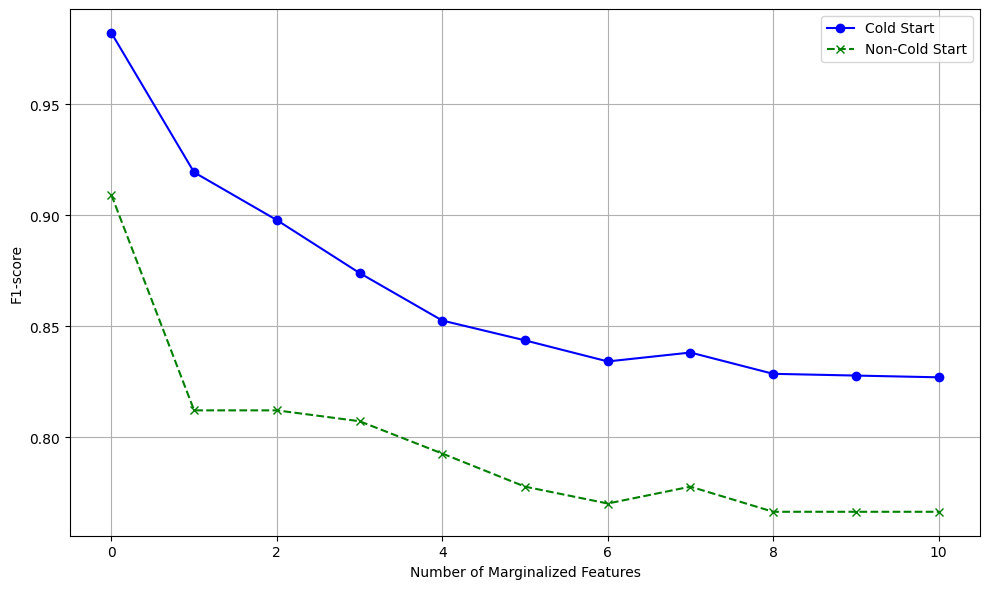

In [17]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    # plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 0  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [11]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 0  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: database, Importance = 0.0595
Feature: oracle, Importance = 0.0036
Feature: sql, Importance = 0.0036
Feature: mysql, Importance = 0.0026
Feature: query, Importance = 0.0018
Feature: administrator, Importance = 0.0017
Feature: account, Importance = 0.0009
Feature: administration, Importance = 0.0009
Feature: backup, Importance = 0.0009
Feature: center, Importance = 0.0009

Top 10 Non-Cold Start Features (Names and Importance):
Feature: database, Importance = 0.0827
Feature: oracle, Importance = 0.0062
Feature: sql, Importance = 0.0062
Feature: tuning, Importance = 0.0062
Feature: application, Importance = 0.0051
Feature: budget, Importance = 0.0051
Feature: developer, Importance = 0.0051
Feature: extensively, Importance = 0.0051
Feature: feature, Importance = 0.0051
Feature: load, Importance = 0.0051

Score Differences (Cold Start - Non-Cold Start):
Feature: database, Score Difference = -0.0232
Feature: oracle, Score Differenc

## Feature Importance Front_End_Developer


In [59]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 1  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 1: 0.6887
Feature 0: Importance for Label 1 = -0.0006
Feature 1: Importance for Label 1 = -0.0018
Feature 2: Importance for Label 1 = -0.0003
Feature 3: Importance for Label 1 = 0.0009
Feature 4: Importance for Label 1 = 0.0021
Feature 5: Importance for Label 1 = 0.0000
Feature 6: Importance for Label 1 = 0.0003
Feature 7: Importance for Label 1 = -0.0074
Feature 8: Importance for Label 1 = -0.0182
Feature 9: Importance for Label 1 = -0.0003
Feature 10: Importance for Label 1 = -0.0006
Feature 11: Importance for Label 1 = -0.0034
Feature 12: Importance for Label 1 = 0.0021
Feature 13: Importance for Label 1 = -0.0003
Feature 14: Importance for Label 1 = 0.0009
Feature 15: Importance for Label 1 = 0.0000
Feature 16: Importance for Label 1 = 0.0030
Feature 17: Importance for Label 1 = -0.0037
Feature 18: Importance for Label 1 = -0.0080
Feature 19: Importance for Label 1 = -0.0003
Feature 20: Importance for Label 1 = 0.0087
Feature 21: Importance for Label 1 =

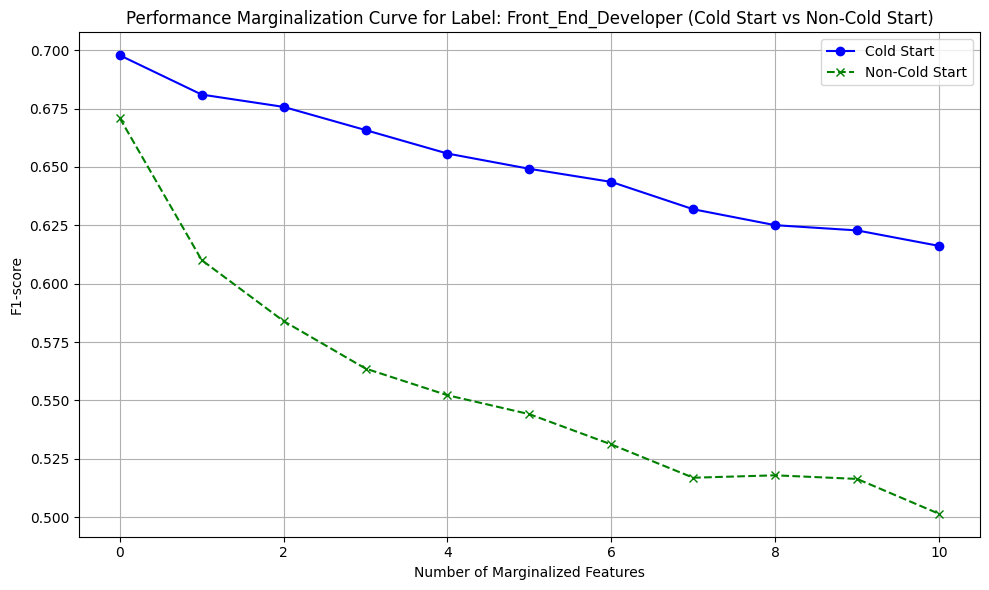

In [60]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 1  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [61]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 1  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: java, Importance = 0.0168
Feature: software, Importance = 0.0096
Feature: python, Importance = 0.0078
Feature: api, Importance = 0.0051
Feature: php, Importance = 0.0046
Feature: mvc, Importance = 0.0037
Feature: operation, Importance = 0.0033
Feature: backend, Importance = 0.0028
Feature: framework, Importance = 0.0028
Feature: net, Importance = 0.0028

Top 10 Non-Cold Start Features (Names and Importance):
Feature: java, Importance = 0.0616
Feature: python, Importance = 0.0250
Feature: logic, Importance = 0.0227
Feature: soap, Importance = 0.0186
Feature: ide, Importance = 0.0185
Feature: developed, Importance = 0.0178
Feature: jenkins, Importance = 0.0169
Feature: end, Importance = 0.0154
Feature: class, Importance = 0.0145
Feature: framework, Importance = 0.0145

Score Differences (Cold Start - Non-Cold Start):
Feature: java, Score Difference = -0.0448
Feature: software, Score Difference = -0.0154
Feature: python, Score D

# Feature Importance Java Developer

In [62]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 2  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 2: 0.8035
Feature 0: Importance for Label 2 = 0.0025
Feature 1: Importance for Label 2 = 0.0010
Feature 2: Importance for Label 2 = -0.0026
Feature 3: Importance for Label 2 = 0.0010
Feature 4: Importance for Label 2 = 0.0076
Feature 5: Importance for Label 2 = 0.0101
Feature 6: Importance for Label 2 = -0.0015
Feature 7: Importance for Label 2 = -0.0051
Feature 8: Importance for Label 2 = -0.0457
Feature 9: Importance for Label 2 = 0.0000
Feature 10: Importance for Label 2 = -0.0005
Feature 11: Importance for Label 2 = 0.0035
Feature 12: Importance for Label 2 = -0.0469
Feature 13: Importance for Label 2 = -0.0031
Feature 14: Importance for Label 2 = 0.0106
Feature 15: Importance for Label 2 = 0.0015
Feature 16: Importance for Label 2 = 0.0005
Feature 17: Importance for Label 2 = -0.0031
Feature 18: Importance for Label 2 = 0.0115
Feature 19: Importance for Label 2 = -0.0161
Feature 20: Importance for Label 2 = 0.0010
Feature 21: Importance for Label 2 = -0

In [63]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 2  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0705
Feature: django, Importance = 0.0681
Feature: web, Importance = 0.0464
Feature: javascript, Importance = 0.0370
Feature: software, Importance = 0.0357
Feature: git, Importance = 0.0316
Feature: html, Importance = 0.0316
Feature: bootstrap, Importance = 0.0302
Feature: framework, Importance = 0.0302
Feature: using, Importance = 0.0288

Top 10 Non-Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0497
Feature: django, Importance = 0.0477
Feature: using, Importance = 0.0366
Feature: framework, Importance = 0.0338
Feature: scripting, Importance = 0.0310
Feature: mysql, Importance = 0.0289
Feature: data, Importance = 0.0281
Feature: web, Importance = 0.0274
Feature: javascript, Importance = 0.0245
Feature: stored, Importance = 0.0238

Score Differences (Cold Start - Non-Cold Start):
Feature: python, Score Difference = 0.0208
Feature: django, Score Difference = 0.0204
Feature: w

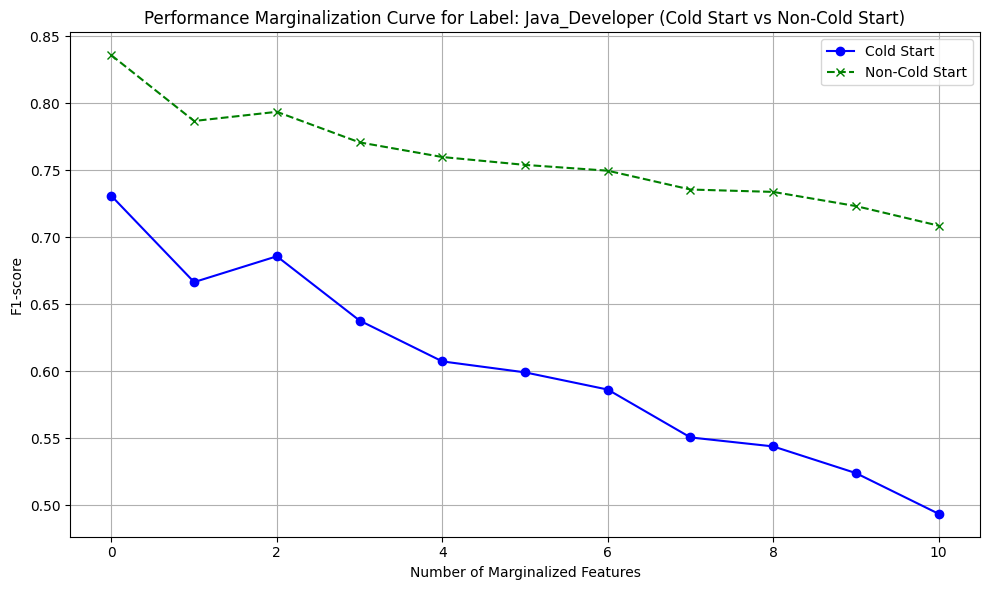

In [64]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 2  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


# Feature Importance Network Administrator

In [65]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 3  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 3: 0.7614
Feature 0: Importance for Label 3 = -0.0007
Feature 1: Importance for Label 3 = 0.0003
Feature 2: Importance for Label 3 = 0.0046
Feature 3: Importance for Label 3 = -0.0019
Feature 4: Importance for Label 3 = 0.0033
Feature 5: Importance for Label 3 = 0.0013
Feature 6: Importance for Label 3 = 0.0021
Feature 7: Importance for Label 3 = -0.0131
Feature 8: Importance for Label 3 = -0.0002
Feature 9: Importance for Label 3 = -0.0024
Feature 10: Importance for Label 3 = -0.0035
Feature 11: Importance for Label 3 = 0.0016
Feature 12: Importance for Label 3 = -0.0003
Feature 13: Importance for Label 3 = -0.0010
Feature 14: Importance for Label 3 = 0.0044
Feature 15: Importance for Label 3 = 0.0000
Feature 16: Importance for Label 3 = 0.0000
Feature 17: Importance for Label 3 = 0.0003
Feature 18: Importance for Label 3 = 0.0000
Feature 19: Importance for Label 3 = 0.0006
Feature 20: Importance for Label 3 = -0.0028
Feature 21: Importance for Label 3 = -0

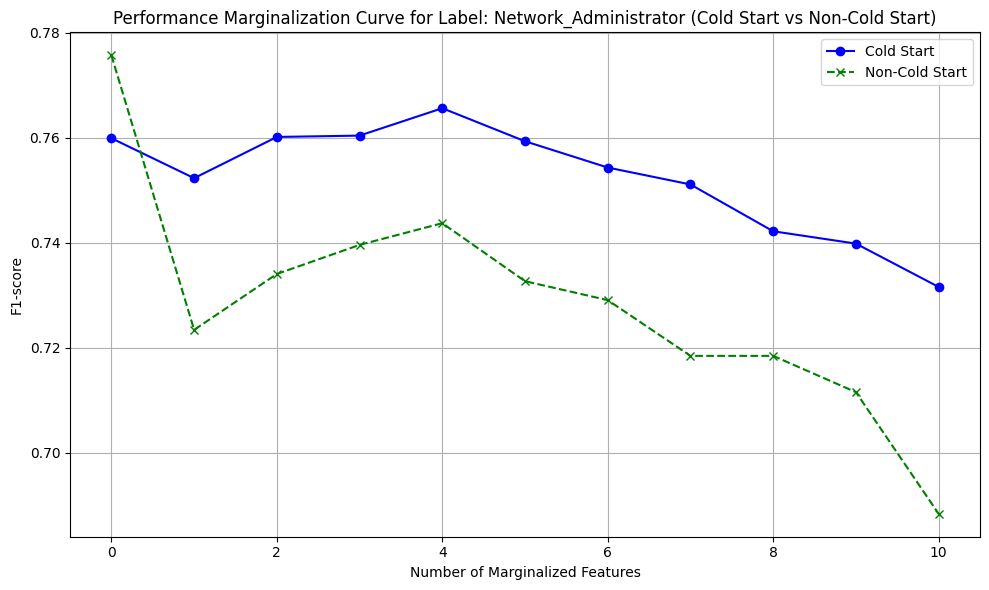

In [66]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 3  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [67]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 3  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: network, Importance = 0.0251
Feature: span, Importance = 0.0099
Feature: server, Importance = 0.0077
Feature: technician, Importance = 0.0073
Feature: virtual, Importance = 0.0072
Feature: designed, Importance = 0.0068
Feature: manager, Importance = 0.0065
Feature: account, Importance = 0.0060
Feature: code, Importance = 0.0058
Feature: installation, Importance = 0.0058

Top 10 Non-Cold Start Features (Names and Importance):
Feature: network, Importance = 0.0175
Feature: project, Importance = 0.0099
Feature: status, Importance = 0.0086
Feature: activity, Importance = 0.0072
Feature: analyst, Importance = 0.0072
Feature: asset, Importance = 0.0072
Feature: dynamic, Importance = 0.0072
Feature: multiple, Importance = 0.0072
Feature: manager, Importance = 0.0065
Feature: installation, Importance = 0.0051

Score Differences (Cold Start - Non-Cold Start):
Feature: network, Score Difference = 0.0076
Feature: span, Score Difference 

# Feature Importance 4

In [68]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 4  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 4: 0.9307
Feature 0: Importance for Label 4 = 0.0006
Feature 1: Importance for Label 4 = 0.0035
Feature 2: Importance for Label 4 = 0.0010
Feature 3: Importance for Label 4 = 0.0021
Feature 4: Importance for Label 4 = 0.0005
Feature 5: Importance for Label 4 = 0.0011
Feature 6: Importance for Label 4 = 0.0005
Feature 7: Importance for Label 4 = 0.0004
Feature 8: Importance for Label 4 = 0.0232
Feature 9: Importance for Label 4 = 0.0005
Feature 10: Importance for Label 4 = 0.0015
Feature 11: Importance for Label 4 = 0.0001
Feature 12: Importance for Label 4 = 0.0001
Feature 13: Importance for Label 4 = -0.0004
Feature 14: Importance for Label 4 = 0.0041
Feature 15: Importance for Label 4 = 0.0006
Feature 16: Importance for Label 4 = 0.0005
Feature 17: Importance for Label 4 = 0.0021
Feature 18: Importance for Label 4 = 0.0006
Feature 19: Importance for Label 4 = 0.0005
Feature 20: Importance for Label 4 = 0.0011
Feature 21: Importance for Label 4 = 0.0006
Fea

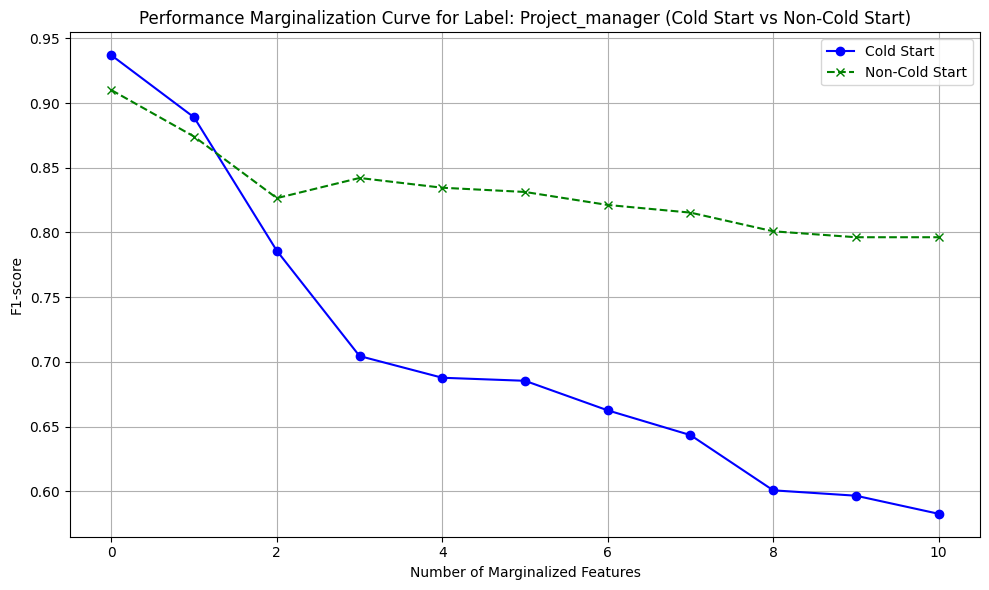

In [69]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 4  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [70]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 4  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: manager, Importance = 0.0483
Feature: project, Importance = 0.0453
Feature: administrator, Importance = 0.0238
Feature: information, Importance = 0.0068
Feature: analyst, Importance = 0.0054
Feature: network, Importance = 0.0046
Feature: security, Importance = 0.0043
Feature: website, Importance = 0.0037
Feature: access, Importance = 0.0033
Feature: python, Importance = 0.0032

Top 10 Non-Cold Start Features (Names and Importance):
Feature: manager, Importance = 0.0479
Feature: project, Importance = 0.0304
Feature: administrator, Importance = 0.0061
Feature: analyst, Importance = 0.0044
Feature: incident, Importance = 0.0044
Feature: network, Importance = 0.0044
Feature: developer, Importance = 0.0027
Feature: github, Importance = 0.0027
Feature: access, Importance = 0.0022
Feature: analysis, Importance = 0.0022

Score Differences (Cold Start - Non-Cold Start):
Feature: manager, Score Difference = 0.0004
Feature: project, Sco

# Feature importance 5

In [71]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 5  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 5: 0.9466
Feature 0: Importance for Label 5 = 0.0000
Feature 1: Importance for Label 5 = -0.0008
Feature 2: Importance for Label 5 = 0.0000
Feature 3: Importance for Label 5 = 0.0000
Feature 4: Importance for Label 5 = -0.0008
Feature 5: Importance for Label 5 = 0.0017
Feature 6: Importance for Label 5 = 0.0008
Feature 7: Importance for Label 5 = 0.0009
Feature 8: Importance for Label 5 = -0.0015
Feature 9: Importance for Label 5 = 0.0000
Feature 10: Importance for Label 5 = 0.0000
Feature 11: Importance for Label 5 = -0.0007
Feature 12: Importance for Label 5 = -0.0007
Feature 13: Importance for Label 5 = -0.0008
Feature 14: Importance for Label 5 = 0.0017
Feature 15: Importance for Label 5 = 0.0000
Feature 16: Importance for Label 5 = 0.0000
Feature 17: Importance for Label 5 = 0.0008
Feature 18: Importance for Label 5 = -0.0008
Feature 19: Importance for Label 5 = 0.0000
Feature 20: Importance for Label 5 = 0.0008
Feature 21: Importance for Label 5 = 0.00

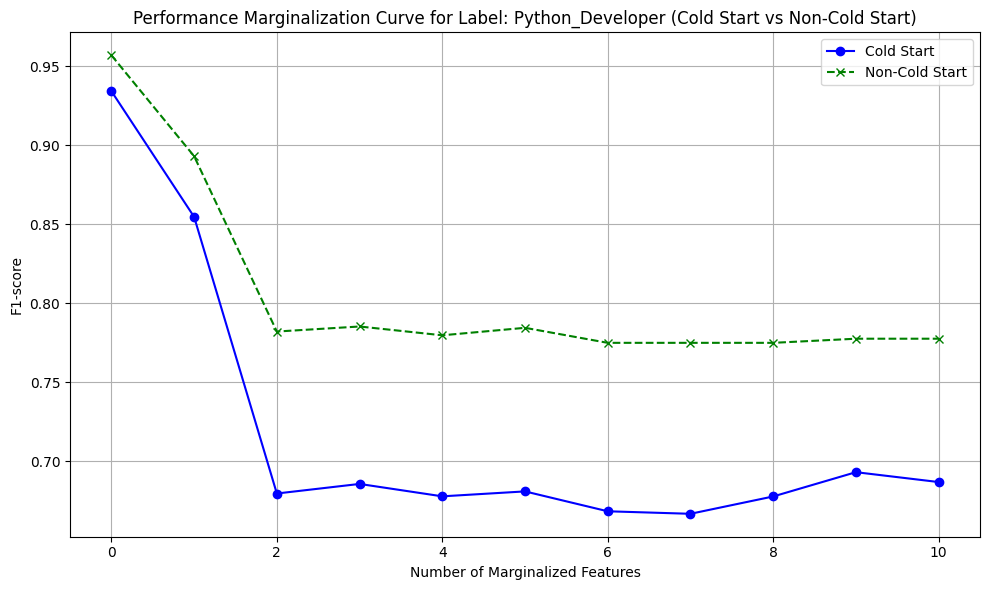

In [72]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 5  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [73]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 5  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0730
Feature: django, Importance = 0.0152
Feature: software, Importance = 0.0125
Feature: like, Importance = 0.0059
Feature: stored, Importance = 0.0059
Feature: education, Importance = 0.0057
Feature: mvc, Importance = 0.0057
Feature: source, Importance = 0.0057
Feature: collection, Importance = 0.0054
Feature: hibernate, Importance = 0.0054

Top 10 Non-Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0608
Feature: django, Importance = 0.0255
Feature: cloud, Importance = 0.0016
Feature: cluster, Importance = 0.0016
Feature: configure, Importance = 0.0016
Feature: designed, Importance = 0.0016
Feature: extensively, Importance = 0.0016
Feature: external, Importance = 0.0016
Feature: handling, Importance = 0.0016
Feature: like, Importance = 0.0016

Score Differences (Cold Start - Non-Cold Start):
Feature: python, Score Difference = 0.0122
Feature: django, Score Difference = -0.0

# Feature Importance 6

In [74]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 6  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 6: 0.9507
Feature 0: Importance for Label 6 = -0.0008
Feature 1: Importance for Label 6 = -0.0046
Feature 2: Importance for Label 6 = 0.0000
Feature 3: Importance for Label 6 = -0.0015
Feature 4: Importance for Label 6 = 0.0023
Feature 5: Importance for Label 6 = -0.0023
Feature 6: Importance for Label 6 = -0.0015
Feature 7: Importance for Label 6 = 0.0008
Feature 8: Importance for Label 6 = 0.0461
Feature 9: Importance for Label 6 = -0.0015
Feature 10: Importance for Label 6 = -0.0008
Feature 11: Importance for Label 6 = -0.0015
Feature 12: Importance for Label 6 = 0.0008
Feature 13: Importance for Label 6 = -0.0015
Feature 14: Importance for Label 6 = 0.0082
Feature 15: Importance for Label 6 = -0.0008
Feature 16: Importance for Label 6 = 0.0000
Feature 17: Importance for Label 6 = -0.0008
Feature 18: Importance for Label 6 = -0.0008
Feature 19: Importance for Label 6 = -0.0015
Feature 20: Importance for Label 6 = -0.0015
Feature 21: Importance for Label 6

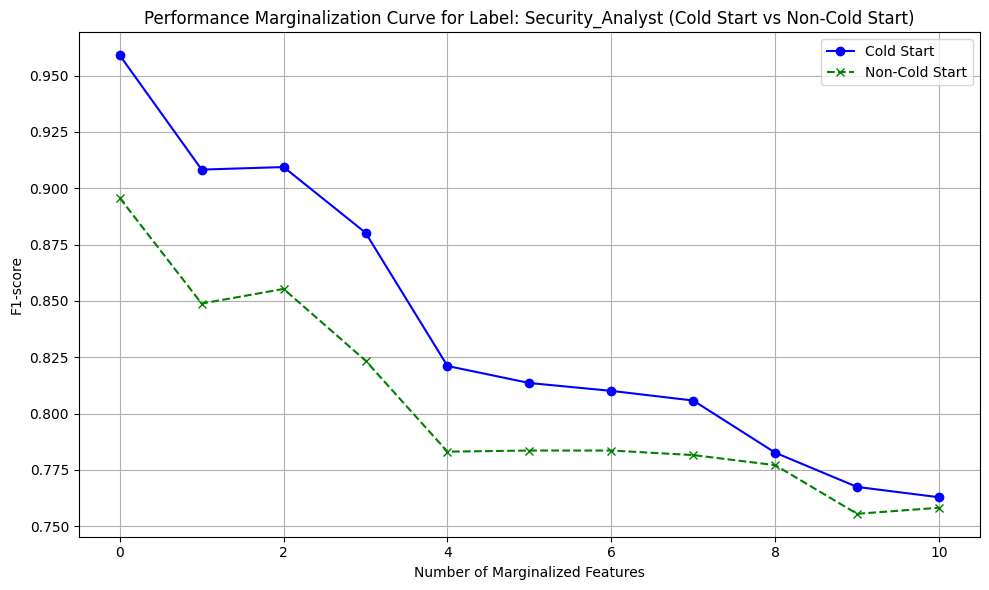

In [75]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 6  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [76]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 6  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: administrator, Importance = 0.0523
Feature: security, Importance = 0.0364
Feature: switch, Importance = 0.0141
Feature: training, Importance = 0.0062
Feature: equipment, Importance = 0.0053
Feature: hardware, Importance = 0.0036
Feature: monitor, Importance = 0.0036
Feature: project, Importance = 0.0036
Feature: python, Importance = 0.0036
Feature: related, Importance = 0.0036

Top 10 Non-Cold Start Features (Names and Importance):
Feature: administrator, Importance = 0.0469
Feature: security, Importance = 0.0422
Feature: switch, Importance = 0.0267
Feature: manager, Importance = 0.0162
Feature: project, Importance = 0.0162
Feature: testing, Importance = 0.0162
Feature: analyst, Importance = 0.0152
Feature: access, Importance = 0.0123
Feature: provides, Importance = 0.0109
Feature: patch, Importance = 0.0068

Score Differences (Cold Start - Non-Cold Start):
Feature: administrator, Score Difference = 0.0055
Feature: security, 

# Feature Importance 7

In [18]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 7  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 7: 0.9870
Feature 0: Importance for Label 7 = -0.0002
Feature 1: Importance for Label 7 = -0.0003
Feature 2: Importance for Label 7 = 0.0002
Feature 3: Importance for Label 7 = 0.0000
Feature 4: Importance for Label 7 = 0.0000
Feature 5: Importance for Label 7 = -0.0002
Feature 6: Importance for Label 7 = -0.0002
Feature 7: Importance for Label 7 = 0.0000
Feature 8: Importance for Label 7 = 0.0007
Feature 9: Importance for Label 7 = -0.0002
Feature 10: Importance for Label 7 = -0.0002
Feature 11: Importance for Label 7 = -0.0002
Feature 12: Importance for Label 7 = 0.0002
Feature 13: Importance for Label 7 = -0.0003
Feature 14: Importance for Label 7 = 0.0000
Feature 15: Importance for Label 7 = -0.0002
Feature 16: Importance for Label 7 = -0.0003
Feature 17: Importance for Label 7 = -0.0002
Feature 18: Importance for Label 7 = -0.0002
Feature 19: Importance for Label 7 = -0.0002
Feature 20: Importance for Label 7 = -0.0003
Feature 21: Importance for Label 7

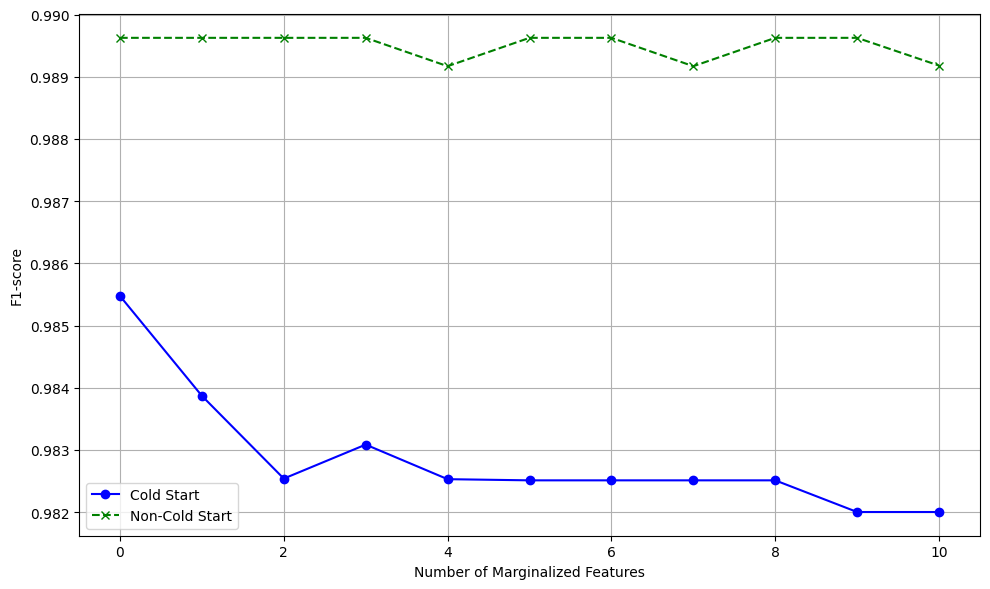

In [19]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    # plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 7  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [20]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 7  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: manager, Importance = 0.0019
Feature: project, Importance = 0.0013
Feature: service, Importance = 0.0011
Feature: network, Importance = 0.0011
Feature: software, Importance = 0.0011
Feature: span, Importance = 0.0011
Feature: desk, Importance = 0.0008
Feature: hardware, Importance = 0.0008
Feature: involved, Importance = 0.0008
Feature: worked, Importance = 0.0008

Top 10 Non-Cold Start Features (Names and Importance):
Feature: administrator, Importance = 0.0005
Feature: networking, Importance = 0.0005
Feature: ability, Importance = 0.0000
Feature: access, Importance = 0.0000
Feature: account, Importance = 0.0000
Feature: active, Importance = 0.0000
Feature: activity, Importance = 0.0000
Feature: additional, Importance = 0.0000
Feature: administration, Importance = 0.0000
Feature: adobe, Importance = 0.0000

Score Differences (Cold Start - Non-Cold Start):
Feature: manager, Score Difference = 0.0014
Feature: project, Score Di

# Feature Importance 8

In [80]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 8 # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 8: 0.7810
Feature 0: Importance for Label 8 = 0.0007
Feature 1: Importance for Label 8 = 0.0013
Feature 2: Importance for Label 8 = 0.0001
Feature 3: Importance for Label 8 = -0.0003
Feature 4: Importance for Label 8 = 0.0011
Feature 5: Importance for Label 8 = 0.0031
Feature 6: Importance for Label 8 = 0.0016
Feature 7: Importance for Label 8 = -0.0026
Feature 8: Importance for Label 8 = 0.0193
Feature 9: Importance for Label 8 = 0.0019
Feature 10: Importance for Label 8 = 0.0011
Feature 11: Importance for Label 8 = -0.0037
Feature 12: Importance for Label 8 = 0.0011
Feature 13: Importance for Label 8 = 0.0018
Feature 14: Importance for Label 8 = 0.0182
Feature 15: Importance for Label 8 = -0.0004
Feature 16: Importance for Label 8 = 0.0000
Feature 17: Importance for Label 8 = 0.0001
Feature 18: Importance for Label 8 = 0.0022
Feature 19: Importance for Label 8 = 0.0038
Feature 20: Importance for Label 8 = 0.0014
Feature 21: Importance for Label 8 = 0.0008


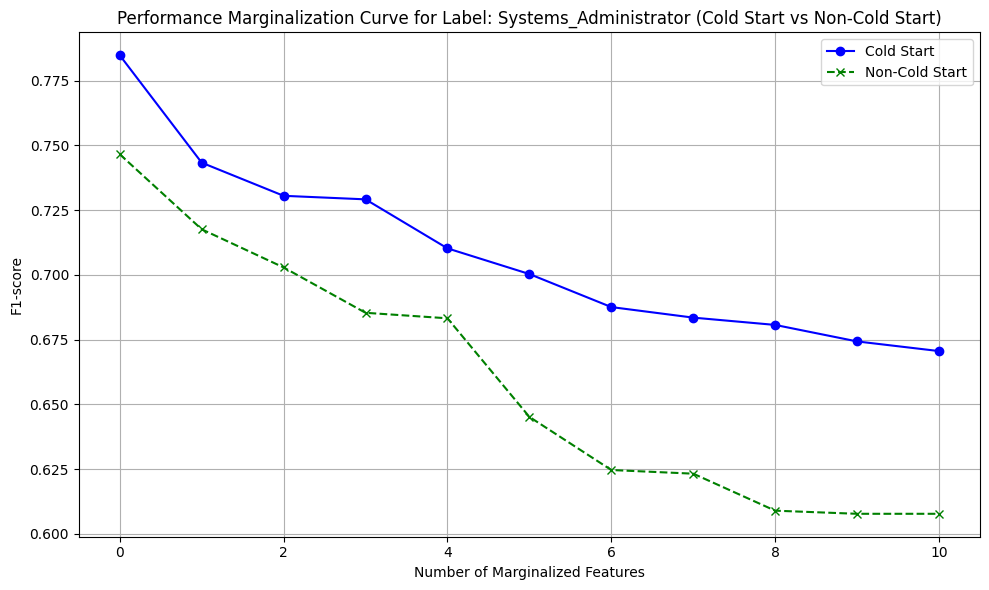

In [81]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 8  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [82]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 8 # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: database, Importance = 0.0343
Feature: administrator, Importance = 0.0223
Feature: security, Importance = 0.0203
Feature: analyst, Importance = 0.0154
Feature: manager, Importance = 0.0075
Feature: maven, Importance = 0.0059
Feature: sql, Importance = 0.0056
Feature: risk, Importance = 0.0055
Feature: project, Importance = 0.0053
Feature: apache, Importance = 0.0043

Top 10 Non-Cold Start Features (Names and Importance):
Feature: administrator, Importance = 0.0442
Feature: database, Importance = 0.0337
Feature: manager, Importance = 0.0300
Feature: security, Importance = 0.0193
Feature: analyst, Importance = 0.0175
Feature: wrote, Importance = 0.0101
Feature: risk, Importance = 0.0083
Feature: activity, Importance = 0.0076
Feature: audit, Importance = 0.0076
Feature: maven, Importance = 0.0076

Score Differences (Cold Start - Non-Cold Start):
Feature: database, Score Difference = -0.0099
Feature: administrator, Score Differen

# Feature Importance 9

In [83]:
# ============================
# Compute Permutation Importance for Specific Label
# ============================
import numpy as np
import torch
from sklearn.metrics import classification_report

# =======================
# Permute Specific Feature
# =======================
def permute_feature(data, feature_idx, num_resume_nodes):
    """
    Permutes a single feature column for resume nodes in the dataset.

    Args:
        data (torch_geometric.data.Data): The graph data.
        feature_idx (int): Index of the feature to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.

    Returns:
        torch_geometric.data.Data: New dataset with the specified feature permuted.
    """
    data_permuted = data.clone()
    resume_features = data_permuted.x[:num_resume_nodes]  # Only permute resume features
    resume_features[:, feature_idx] = torch.from_numpy(
        np.random.permutation(resume_features[:, feature_idx].cpu().numpy())
    )
    data_permuted.x[:num_resume_nodes] = resume_features
    return data_permuted

def compute_permutation_importance_for_label(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx):
    """
    Computes permutation importance for a specific target label by permuting and evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.

    Returns:
        list: Sorted feature importances (feature_idx, importance score).
    """
    # Evaluate baseline performance for the specific label
    model.eval()
    with torch.no_grad():
        baseline_out = model(data)
        baseline_preds = (torch.sigmoid(baseline_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    print(f"Baseline F1-Score for Label {target_label_idx}: {baseline_score:.4f}")

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        data_permuted = permute_feature(data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_out = model(data_permuted)
            permuted_preds = (torch.sigmoid(permuted_out[data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

        print(f"Feature {feature_idx}: Importance for Label {target_label_idx} = {importance:.4f}")

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ============================
# Running the Pipeline for Specific Label
# ============================
# Specify the target label index
target_label_idx = 9  # Example: change to the desired label index

# Assuming `data` and `final_model` are already prepared
num_resume_nodes = len(train_idx) + len(val_idx) + len(test_idx)  # Count of resume nodes
features_to_permute = list(range(data.num_node_features))  # All TF-IDF features

# Compute Permutation Importance for the target label
feature_importances_label = compute_permutation_importance_for_label(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx
)

# Retrieve the top 10 most important features for the target label
top_10_features_label = feature_importances_label[:10]

print(f"\nTop 10 Most Important Features for Label {mlb.classes_[target_label_idx]}:")
for feature_idx, importance in top_10_features_label:
    print(f"Feature {feature_idx}: Importance = {importance:.4f}")

# Map feature indices back to feature names
top_10_feature_names_label = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in top_10_features_label]

print(f"\nTop 10 Most Important Features (Names) for Label {mlb.classes_[target_label_idx]}:")
for feature_name, importance in top_10_feature_names_label:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")


Baseline F1-Score for Label 9: 0.7069
Feature 0: Importance for Label 9 = -0.0004
Feature 1: Importance for Label 9 = 0.0002
Feature 2: Importance for Label 9 = -0.0004
Feature 3: Importance for Label 9 = -0.0002
Feature 4: Importance for Label 9 = 0.0002
Feature 5: Importance for Label 9 = 0.0018
Feature 6: Importance for Label 9 = -0.0013
Feature 7: Importance for Label 9 = -0.0013
Feature 8: Importance for Label 9 = -0.0037
Feature 9: Importance for Label 9 = 0.0010
Feature 10: Importance for Label 9 = 0.0006
Feature 11: Importance for Label 9 = 0.0005
Feature 12: Importance for Label 9 = 0.0012
Feature 13: Importance for Label 9 = 0.0014
Feature 14: Importance for Label 9 = 0.0004
Feature 15: Importance for Label 9 = -0.0002
Feature 16: Importance for Label 9 = 0.0002
Feature 17: Importance for Label 9 = 0.0010
Feature 18: Importance for Label 9 = 0.0002
Feature 19: Importance for Label 9 = -0.0002
Feature 20: Importance for Label 9 = 0.0019
Feature 21: Importance for Label 9 = 0.0

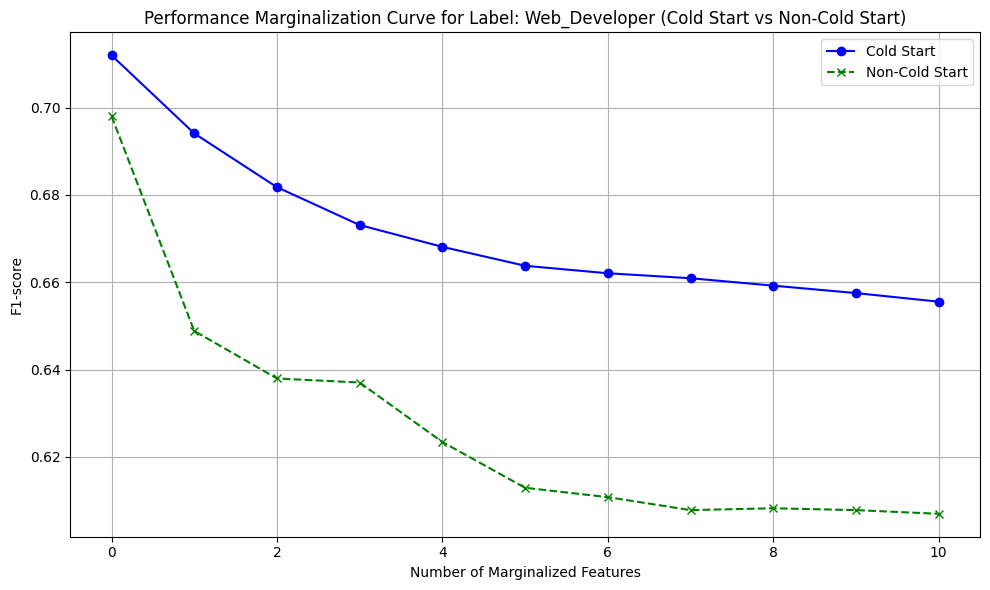

In [84]:
import matplotlib.pyplot as plt

# =======================
# Compute Marginalization Curve for Specific Target Label and Cluster
# =======================
def compute_marginalization_curve_for_label_and_cluster(model, data, mlb, top_features, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes a performance marginalization curve for a specific target label within a specific cluster
    (cold start or non-cold start) by progressively permuting top-ranked features.

    Args:
        model: Trained PyTorch model.
        data: PyG data object.
        mlb: MultiLabelBinarizer for labels.
        top_features: List of top-ranked feature indices to marginalize.
        num_resume_nodes: Number of resume nodes in the graph.
        target_label_idx: Index of the target label.
        cluster_indices: Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Marginalized performance scores for each step.
    """
    model.eval()
    marginalization_scores = []

    # Clone data to avoid modifying the original dataset
    data_permuted = data.clone()

    # Adjust test_mask for the specific cluster
    data_permuted.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(data_permuted)
        baseline_preds = (torch.sigmoid(baseline_output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = data.y[data_permuted.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    marginalization_scores.append(baseline_score)

    # Permute features one by one, cumulatively
    for feature_idx in top_features:
        original_feature_column = data_permuted.x[:num_resume_nodes, feature_idx].clone()
        permuted_features = original_feature_column[torch.randperm(num_resume_nodes)]
        data_permuted.x[:num_resume_nodes, feature_idx] = permuted_features

        with torch.no_grad():
            output = model(data_permuted)
            permuted_preds = (torch.sigmoid(output[data_permuted.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        marginalization_scores.append(permuted_score)

    return marginalization_scores

# =======================
# Plot Marginalization Curve for Both Clusters
# =======================
def plot_marginalization_curve_for_both_clusters(cold_start_scores, non_cold_start_scores, num_features, label_name):
    """
    Plots the performance marginalization curve for both cold start and non-cold start clusters.

    Args:
        cold_start_scores (list): List of performance scores for cold start instances after marginalization.
        non_cold_start_scores (list): List of performance scores for non-cold start instances after marginalization.
        num_features (int): Number of marginalized features.
        label_name (str): Name of the target label.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_features + 1), cold_start_scores, marker='o', linestyle='-', color='blue', label='Cold Start')
    plt.plot(range(num_features + 1), non_cold_start_scores, marker='x', linestyle='--', color='green', label='Non-Cold Start')

    plt.xlabel("Number of Marginalized Features")
    plt.ylabel("F1-score")
    plt.title(f"Performance Marginalization Curve for Label: {label_name} (Cold Start vs Non-Cold Start)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# =======================
# Running the Pipeline for Specific Label and Clusters
# =======================
# Specify the target label index
target_label_idx = 9  # Example: Change to the desired label index
target_label_name = mlb.classes_[target_label_idx]  # Get the name of the label

# Define cold start and non-cold start cluster indices
cold_start_indices = cold_start_test_indices  # Replace with your cold start indices
non_cold_start_indices = non_cold_start_test_indices  # Replace with your non-cold start indices

# Extract top feature indices for the specific label (use previously computed importance)
top_10_indices = [feature_idx for feature_idx, _ in feature_importances_label[:10]]  # Adjust as needed

# Compute the marginalization curve for cold start
cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, cold_start_indices
)

# Compute the marginalization curve for non-cold start
non_cold_start_marginalization_scores = compute_marginalization_curve_for_label_and_cluster(
    final_model, data, mlb, top_10_indices, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Plot the comparison curve for both clusters
plot_marginalization_curve_for_both_clusters(
    cold_start_marginalization_scores,
    non_cold_start_marginalization_scores,
    len(top_10_indices),
    target_label_name
)


In [85]:
# ===========================
# Compute Cluster-Specific Permutation Importance
# ===========================
def compute_cluster_specific_permutation_importance(model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cluster_indices):
    """
    Computes permutation importance for a specific target label within a specific cluster
    (cold start or non-cold start) by evaluating performance drop.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): The graph data.
        mlb (MultiLabelBinarizer): Multi-label binarizer for target labels.
        features_to_permute (list): Indices of features to permute.
        num_resume_nodes (int): Number of resume nodes in the graph.
        target_label_idx (int): Index of the target label for which to compute importance.
        cluster_indices (list): Indices of the cluster (cold start or non-cold start).

    Returns:
        list: Sorted feature importances (feature_idx, importance score) for the cluster.
    """
    model.eval()

    # Adjust the test mask for the cluster
    cluster_data = data.clone()
    cluster_data.test_mask = torch.tensor([True if i in cluster_indices else False for i in range(len(data.y))])

    # Evaluate baseline performance for the specific label and cluster
    with torch.no_grad():
        baseline_output = model(cluster_data)
        baseline_preds = (torch.sigmoid(baseline_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
        baseline_true = cluster_data.y[cluster_data.test_mask][:, target_label_idx].cpu().numpy()
        baseline_score = f1_score(baseline_true, baseline_preds)

    feature_importances = []

    # Loop through features and compute importance
    for feature_idx in features_to_permute:
        cluster_data_permuted = permute_feature(cluster_data, feature_idx, num_resume_nodes)
        with torch.no_grad():
            permuted_output = model(cluster_data_permuted)
            permuted_preds = (torch.sigmoid(permuted_output[cluster_data.test_mask])[:, target_label_idx] >= 0.5).cpu().numpy()
            permuted_score = f1_score(baseline_true, permuted_preds)

        importance = baseline_score - permuted_score
        feature_importances.append((feature_idx, importance))

    # Sort by importance descending
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return feature_importances

# ===========================
# Compute and Compare Cluster-Specific Feature Importance
# ===========================
target_label_idx = 9  # Example: Change to the desired label index
# Compute permutation importance for cold start and non-cold start
cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, cold_start_indices
)

non_cold_start_importances = compute_cluster_specific_permutation_importance(
    final_model, data, mlb, features_to_permute, num_resume_nodes, target_label_idx, non_cold_start_indices
)

# Extract feature names and score differences
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in cold_start_importances[:10]]
non_cold_start_feature_names = [(tfidf_feature_names[feature_idx], importance) for feature_idx, importance in non_cold_start_importances[:10]]

# Compute the score differences for shared features in the top 10
score_differences = [
    (tfidf_feature_names[feature_idx], cold_start_score - non_cold_start_score)
    for (feature_idx, cold_start_score), (_, non_cold_start_score)
    in zip(cold_start_importances[:10], non_cold_start_importances[:10])
]

# Print results
print("\nTop 10 Cold Start Features (Names and Importance):")
for feature_name, importance in cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nTop 10 Non-Cold Start Features (Names and Importance):")
for feature_name, importance in non_cold_start_feature_names:
    print(f"Feature: {feature_name}, Importance = {importance:.4f}")

print("\nScore Differences (Cold Start - Non-Cold Start):")
for feature_name, score_diff in score_differences:
    print(f"Feature: {feature_name}, Score Difference = {score_diff:.4f}")



Top 10 Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0176
Feature: software, Importance = 0.0119
Feature: java, Importance = 0.0068
Feature: site, Importance = 0.0042
Feature: shell, Importance = 0.0039
Feature: source, Importance = 0.0032
Feature: db, Importance = 0.0032
Feature: good, Importance = 0.0030
Feature: jenkins, Importance = 0.0029
Feature: tool, Importance = 0.0029

Top 10 Non-Cold Start Features (Names and Importance):
Feature: python, Importance = 0.0526
Feature: developed, Importance = 0.0077
Feature: debugging, Importance = 0.0072
Feature: good, Importance = 0.0072
Feature: web, Importance = 0.0068
Feature: based, Importance = 0.0055
Feature: experienced, Importance = 0.0050
Feature: shell, Importance = 0.0044
Feature: api, Importance = 0.0033
Feature: automation, Importance = 0.0033

Score Differences (Cold Start - Non-Cold Start):
Feature: python, Score Difference = -0.0350
Feature: software, Score Difference = 0.0042
Feature: java, Sco

# Plotting for results

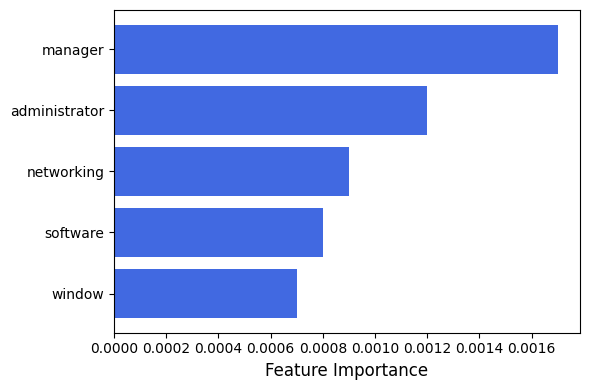

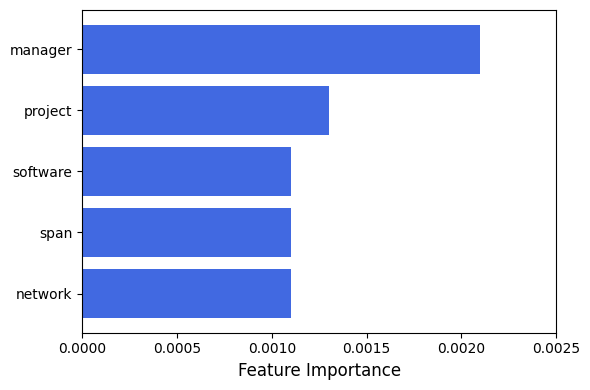

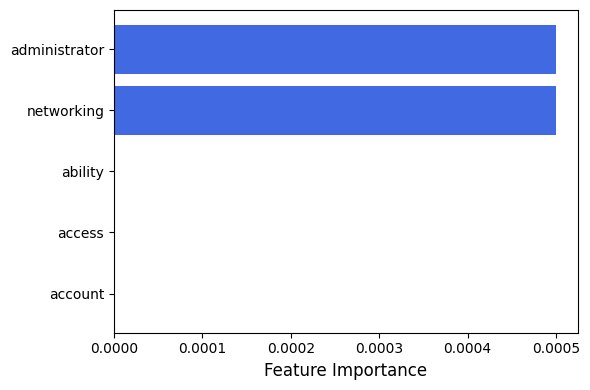

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the top 5 features
categories = ["General", "Cold Start", "Non-Cold Start"]

# Top features and their importance values for each category
features_general = ["manager", "administrator", "networking", "software", "window"]
importance_general = [0.0017, 0.0012, 0.0009, 0.0008, 0.0007]

features_cold_start = ["manager", "project", "software", "span", "network"]
importance_cold_start = [0.0021, 0.0013, 0.0011, 0.0011, 0.0011]

features_non_cold_start = ["administrator", "networking", "ability", "access", "account"]
importance_non_cold_start = [0.0005, 0.0005, 0.0000, 0.0000, 0.0000]

# General Features Plot
plt.figure(figsize=(6, 4))
plt.barh(features_general, importance_general, color="royalblue")
# plt.title("General Features", fontsize=14, fontweight="bold")
plt.xlabel("Feature Importance", fontsize=12)
plt.gca().invert_yaxis()  # Highest to lowest ranking
plt.tight_layout()
plt.savefig("general_features.pdf", format="pdf", dpi=300)
plt.show()

# Cold Start Features Plot
plt.figure(figsize=(6, 4))
plt.barh(features_cold_start, importance_cold_start, color="royalblue")
# plt.title("Cold Start Features", fontsize=14, fontweight="bold")
plt.xlabel("Feature Importance", fontsize=12)
plt.xticks([0.0000, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025])
plt.gca().invert_yaxis()  # Highest to lowest ranking
plt.tight_layout()
plt.savefig("cold_start_features.pdf", format="pdf", dpi=300)
plt.show()

# Non-Cold Start Features Plot
plt.figure(figsize=(6, 4))
plt.barh(features_non_cold_start, importance_non_cold_start, color="royalblue")
# plt.title("Non-Cold Start Features", fontsize=14, fontweight="bold")
plt.xlabel("Feature Importance", fontsize=12)
plt.gca().invert_yaxis()  # Highest to lowest ranking
plt.tight_layout()
plt.savefig("non_cold_start_features.pdf", format="pdf", dpi=300)
plt.show()
